In [1]:
import numpy as np
import tensorflow as tf

import scipy.stats as scipy
from scipy.stats import norm

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
from keras.utils import plot_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Festlegung der Parameter

T     = 30
dt    = T/365
S0    = 100    # Anfangspreis
strike= 100    # Strikepreis
mu    = 0.1    # Expected return
sigma = 0.2    # Volatility
rho   = -0.7   # Korrelationskoeffizient
alpha = 1      # Geschwindigkeit der Rückkehr der Volatilität zu langfrisitgem Mittelwert
b     = 0.04   # Langfristiger Mittelwert der Volatilität
xi    = 2      # Volatilität der 
v0    = 0.04   # Anfangsvolatilität
R     = 10     # Anzahl der trajectoires
N     = 30     # Time Discretization
M     = 1000000
rate  = 0

In [3]:
#Implementierung des Hestonpreises einer europäischen Calloption

spotT = np.empty((M, ))
callT = np.empty((M, ))
for i in range(M):
    z = np.random.normal(size=1) ## pseudorandom numbers
    spotT[i] = S0 * np.exp((rate - 0.5 * sigma * sigma)* T + sigma * np.sqrt(T) * z)
    callT[i] = np.maximum(spotT[i] - strike, 0.0)
    
priceHST = np.exp(-rate * T) * callT.mean()
print("The Call Option Price is: {0:.3f}".format(priceHST))

The Call Option Price is: 73.557


In [4]:
#Definition des neuronalen Netzwerks für Hedging Strategien

m = 2    # Dimension des Preise
d = 2    # Anzahl der Layer in der Strategie
n = 8    # Knoten im ersten und letzten Layer

# Die Architekur ist für alle Netzwerke dieselbe
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0),
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer=initializers.RandomNormal(0,0),
                          name=str(i)+str(j))
        layers = layers + [layer]

In [5]:
#Implementierung der Verlustfunktion aus Deep Hedging

price = Input(shape=(m,))
hedge = Input(shape=(m,))

inputs = [price]+[hedge]


for j in range(N):
    strategy = price
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
    incr = Input(shape=(m,))
    logprice = price
    #logprice = Lambda(lambda x: K.log(x))(price)
    helper1=Lambda(lambda x: np.sqrt(0.04)*x)(logprice)
    helper1=Multiply()([helper1, incr])
    pricenew = Add()([price, helper1])   
    #pricenew = Lambda(lambda x: K.exp(x))(pricenew) # creating the price at time j+1
    priceincr = Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    mult = Input(shape=(m,))
    mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    price = pricenew
    helper2 = Dot(axes=1,normalize=False)([hedge,priceincr])
    helper3 = Lambda(lambda x : K.sum(x,axis=1))(helper2)
    
payoff= Lambda(lambda x : (priceHST + x-strike) - priceHST)(helper3) 
outputs = Subtract()([payoff,hedge]) # payoff minus price minus hedge 

inputs = inputs
outputs= outputs

model_hedge = Model(inputs=inputs, outputs=outputs)

In [6]:
model_hedge.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2)            0           input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 2)            0           lambda_1[0][0]                   
                                                                 input_3[0][0]                    
__________

In [7]:
# Parameter für Erstellen der Trainingsdaten

Szwei0=((v0-b)/alpha)*(1-np.exp(-alpha*T))+b*T #Für die Berücksichtigung des Variance Swaps
Ktrain = 5*10**5
initialprice = [S0]+[Szwei0]

# xtrain besteht aus dem Preis S0, 
# dem Anfangshedging 0 und den Inkrementen des Log-Preis-Prozesses
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.sqrt(dt)*np.random.uniform(0,1,((Ktrain,m))) for i in range(N)])

ytrain=np.zeros((Ktrain,m))

In [8]:
model_hedge.compile(optimizer='adam',loss='mean_squared_error')

In [9]:
for i in range(1):
    model_hedge.fit(x=xtrain, y=ytrain, epochs=10,verbose=True, batch_size=100000)




Epoch 1/10





500000/500000 [==============================] - 23s 45us/step - loss: 6809.9354
Epoch 2/10
500000/500000 [==============================] - 6s 13us/step - loss: 3935.3396
Epoch 3/10
500000/500000 [==============================] - 6s 12us/step - loss: 4313.2465
Epoch 4/10
500000/500000 [==============================] - 7s 13us/step - loss: 3929.5958
Epoch 5/10
500000/500000 [==============================] - 7s 14us/step - loss: 3725.9788
Epoch 6/10
500000/500000 [==============================] - 6s 12us/step - loss: 3764.8642
Epoch 7/10
500000/500000 [==============================] - 7s 15us/step - loss: 3690.1198
Epoch 8/10
500000/500000 [==============================] - 6s 13us/step - loss: 3603.2281
Epoch 9/10
500000/500000 [==============================] - 6s 12us/step - loss: 3573.7724
Epoch 10/10
500000/500000 [==============================] - 8s 15us/step - loss: 3507.8794


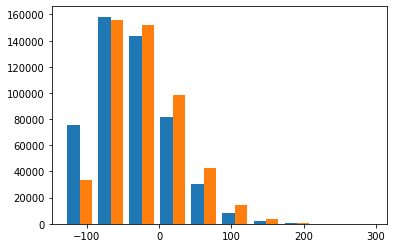

-28.820831
51.25101


<Figure size 432x288 with 0 Axes>

In [14]:
plt.hist(model_hedge.predict(xtrain))
plt.show()
plt.savefig('xtrain_hedge')
print(np.mean(model_hedge.predict(xtrain)))
print(np.std(model_hedge.predict(xtrain)))

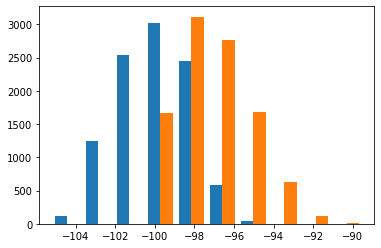

-98.51975
2.312356


<Figure size 432x288 with 0 Axes>

In [15]:
Ltest = 10**4
        
xtest=([initialprice*np.ones((Ltest,m))] +
          [np.zeros((Ltest,m))]+
          [np.sqrt(dt)*np.sqrt(dt)*np.random.uniform(0,1,((Ltest,m))) for i in range(N)])
plt.hist(model_hedge.predict(xtest))
plt.show()
print(np.mean(model_hedge.predict(xtest)))
print(np.std(model_hedge.predict(xtest)))
plt.savefig('xtest_hedge')